In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
import shapely
import skmob

from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

from geopy.distance import geodesic

In [23]:
""" pre-processing
    sorting the event data frame by user ID and then by time is the most critical step.
"""
os.chdir('/Users/owner/Documents/WC_DS/')
events = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_", regex=True)
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       'individual_local_identifier', 'individual_taxon_canonical_name']
tortoise.drop(columns=tortoise.columns.difference(cols), inplace=True)

tortoise.insert(loc = 2, column = "timestamp_UTC",
                value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
                )
tortoise.insert(loc = 3, column = "timestamp_local", 
                value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
                )
tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)
tortoise.insert(loc = 4, column = "minute_diff", 
                value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
                    .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
                    )
tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date
tortoise.reset_index(drop=True, inplace=True)

In [30]:
tortoise

,event_id,timestamp,timestamp_UTC,timestamp_local,minute_diff,location_long,location_lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,individual_taxon_canonical_name,individual_local_identifier,year,month,date,day
0,46119277,2010-09-17 17:01:25.998,2010-09-17 17:01:25.998000+00:00,2010-09-17 10:01:25.998000-07:00,0,-90.241889,-0.635366,18,0.00,334.23,181.1,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,2010-09-17
1,46119278,2010-09-17 18:00:58.001,2010-09-17 18:00:58.001000+00:00,2010-09-17 11:00:58.001000-07:00,59,-90.242230,-0.635563,19,0.21,19.01,143.6,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,2010-09-17
2,46119279,2010-09-17 19:00:56.001,2010-09-17 19:00:56.001000+00:00,2010-09-17 12:00:56.001000-07:00,59,-90.242210,-0.635515,22,0.15,359.14,171.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,2010-09-17
3,46119280,2010-09-17 20:00:29.000,2010-09-17 20:00:29+00:00,2010-09-17 13:00:29-07:00,59,-90.242227,-0.635356,19,0.75,19.66,156.2,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,2010-09-17
4,46119281,2010-09-17 21:00:56.000,2010-09-17 21:00:56+00:00,2010-09-17 14:00:56-07:00,60,-90.242101,-0.635276,17,0.08,342.75,160.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,2010-09-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795887,1751004809,2016-06-16 01:00:26.999,2016-06-16 01:00:26.999000+00:00,2016-06-15 18:00:26.999000-07:00,59,-89.682885,-1.371711,12,0.11,16.38,129.0,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-15,2016-06-16
1795888,1751004810,2016-06-16 11:00:43.999,2016-06-16 11:00:43.999000+00:00,2016-06-16 04:00:43.999000-07:00,600,-89.682925,-1.371698,10,0.64,245.76,127.3,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-16,2016-06-16
1795889,1751004811,2016-06-16 12:00:52.000,2016-06-16 12:00:52+00:00,2016-06-16 05:00:52-07:00,60,-89.682900,-1.371688,9,0.12,285.08,121.8,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-16,2016-06-16
1795890,1751004812,2016-06-16 13:00:10.999,2016-06-16 13:00:10.999000+00:00,2016-06-16 06:00:10.999000-07:00,59,-89.682924,-1.371669,10,0.09,34.73,134.9,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-16,2016-06-16


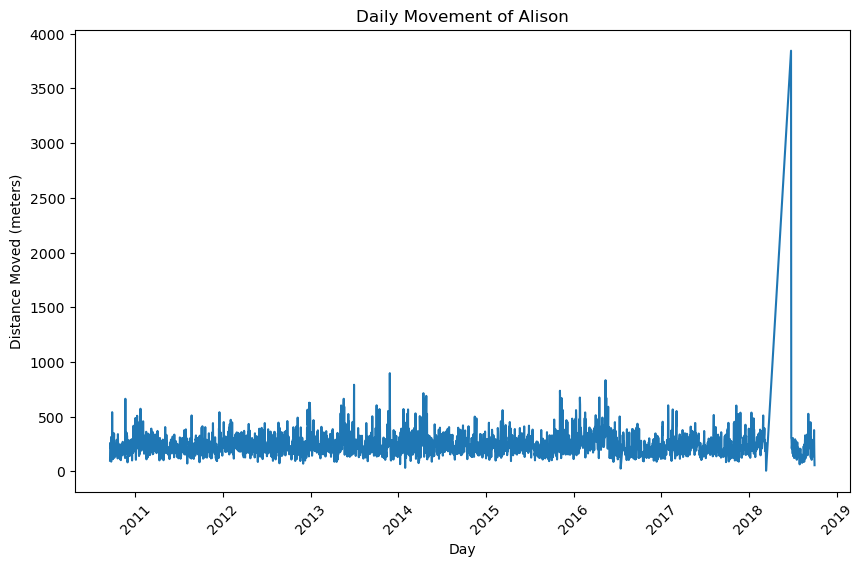

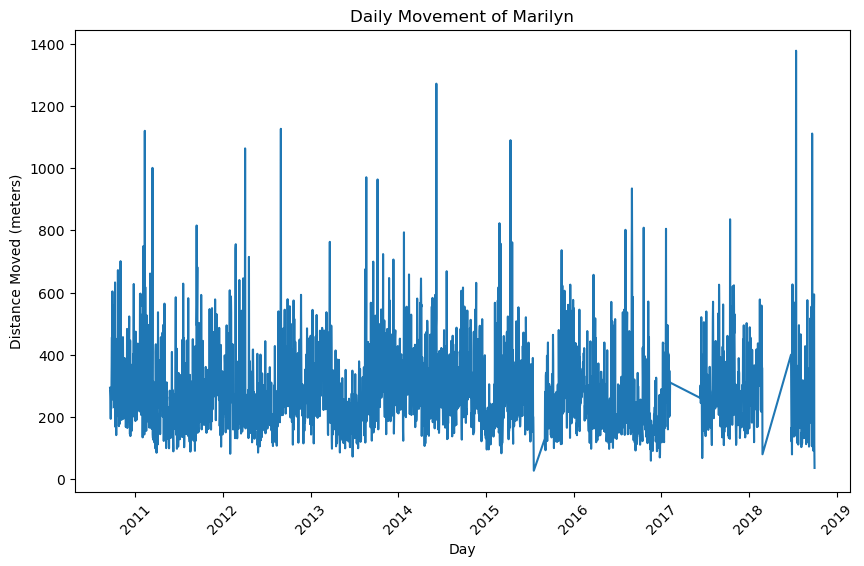

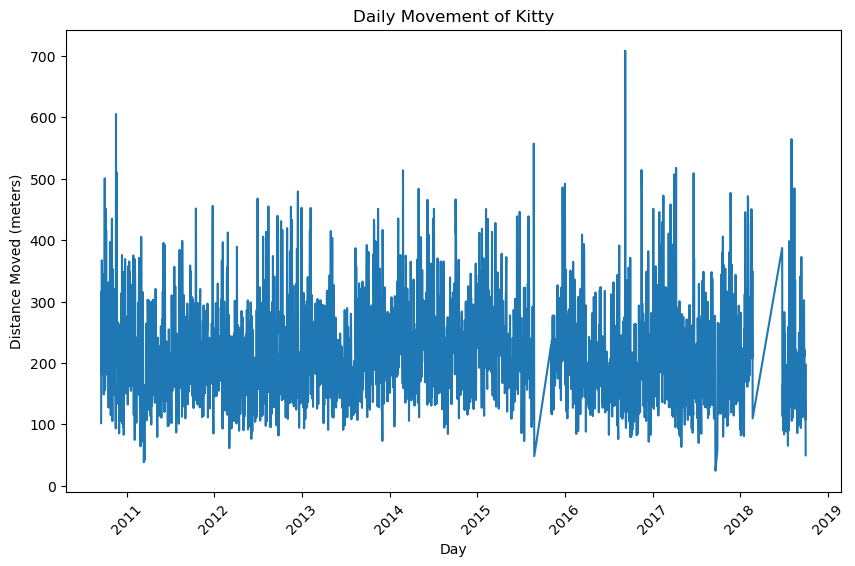

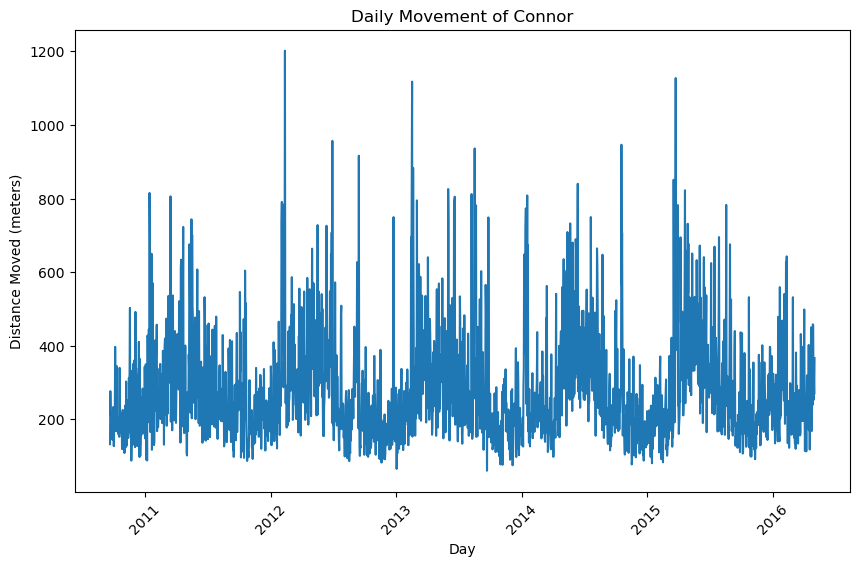

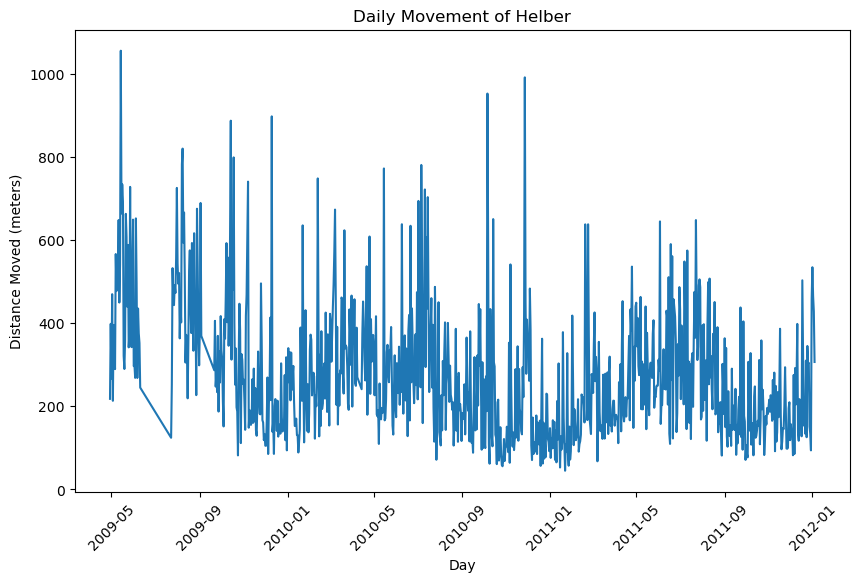

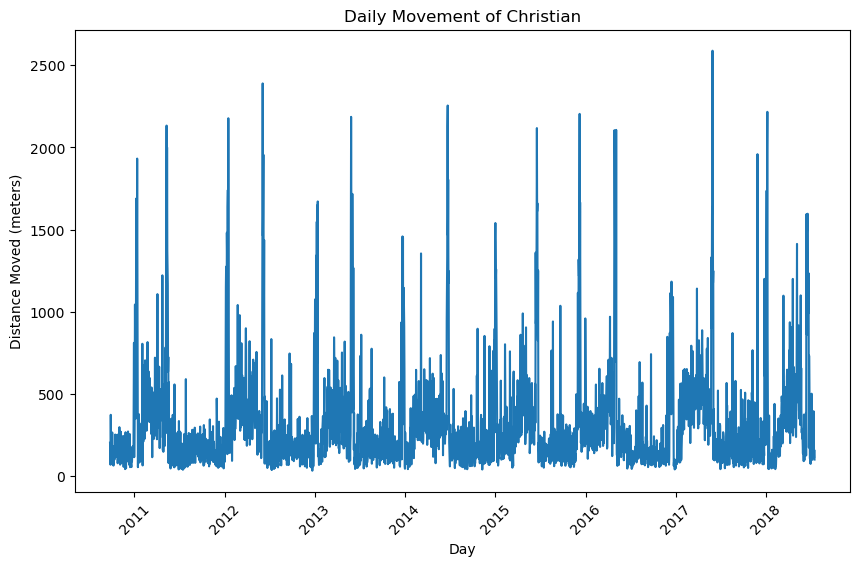

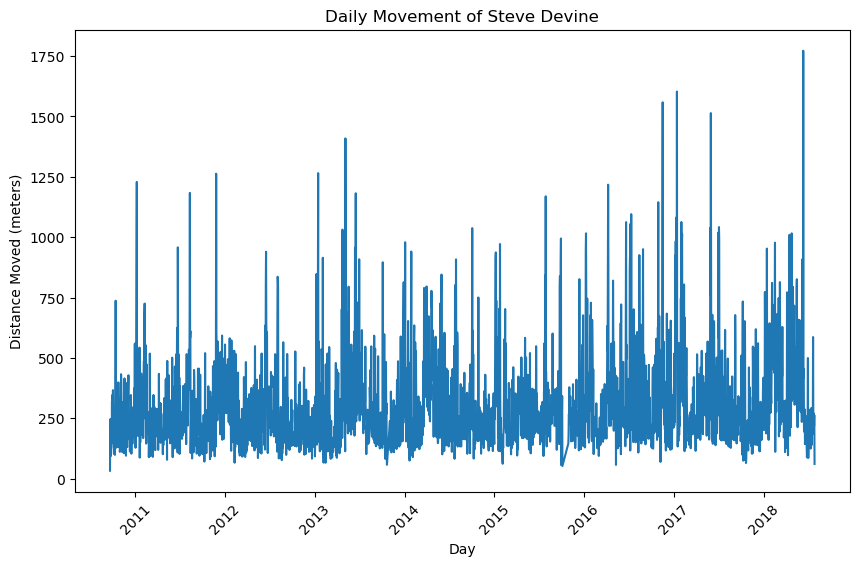

In [26]:
def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

tortoise['day'] = tortoise['timestamp'].dt.date
def compute_daily_movement(df):
    df = df.sort_values(by='timestamp')   
    df['prev_lat'] = df['location_lat'].shift(1)
    df['prev_long'] = df['location_long'].shift(1)   
    df = df.dropna(subset=['location_lat', 'location_long', 'prev_lat', 'prev_long'])   
    df['daily_distance'] = df.apply(
        lambda row: haversine(row['location_lat'], row['location_long'], row['prev_lat'], row['prev_long']), axis=1
    )   
    daily_movement = df.groupby('day')['daily_distance'].sum().reset_index()   
    return daily_movement


tortoises = ['Alison', 'Marilyn', 'Kitty', 'Connor', 'Helber', 'Christian', 'Steve Devine']
migration_periods = {}

for tortoise_id in tortoises:
    tortoise_data = tortoise[tortoise['individual_local_identifier'] == tortoise_id]
    daily_movement = compute_daily_movement(tortoise_data)   
    plt.figure(figsize=(10, 6))
    plt.plot(daily_movement['day'], daily_movement['daily_distance'])
    plt.title(f"Daily Movement of {tortoise_id}")
    plt.xlabel("Day")
    plt.ylabel("Distance Moved (meters)")
    plt.xticks(rotation=45)
    plt.show()
    threshold = daily_movement['daily_distance'].mean() + daily_movement['daily_distance'].std()
    migration_days = daily_movement[daily_movement['daily_distance'] > threshold]
   
    if not migration_days.empty:
        start_migration = migration_days['day'].min()
        end_migration = migration_days['day'].max()
        migration_periods[tortoise_id] = (start_migration, end_migration)

In [31]:
##Conclusions

##Allison migrates on a regular interval at the very beginning of the year and then once again at the middle of the year
##Marilyn migrates around March and October
##Kitty is moving for most of the year but settles for a short amount of time in the middle of the year
##Connor's migration pattern is similar to Marilyn moving initially around March and then again around October
##Helber migrates on a yearly cycle every September
##Christian migrates on a yearly cycle as well every March
##Steve Devine migrates around March and October